In [1]:
import sys
sys.path.append('/Users/pradap/Documents/Research/Python-Package/scaling/dmagellan/')

In [2]:
import os

import pandas as pd
import dask

from dmagellan.blocker.attrequivalence.attr_equiv_blocker import AttrEquivalenceBlocker
from dmagellan.blocker.overlap.overlapblocker import OverlapBlocker
from dmagellan.blocker.blackbox.blackbox_blocker import BlackBoxBlocker
from dmagellan.blocker.rulebased.rule_based_blocker import RuleBasedBlocker
from dmagellan.feature.autofeaturegen import get_features_for_blocking
# 


datapath = "../../datasets/"
A = pd.read_csv(os.path.join(datapath, 'person_table_A.csv'), low_memory=False)
B = pd.read_csv(os.path.join(datapath, 'person_table_B.csv'), low_memory=False)

# A = pd.read_csv(os.path.join(datapath, 'tracks.csv'), low_memory=False)
# B = pd.read_csv(os.path.join(datapath, 'songs.csv'), low_memory=False)

print('Reading the files done')
ab = AttrEquivalenceBlocker()
C = ab.block_tables(A, B, 'ID', 'ID', 'birth_year', 'birth_year', ['name', 'address',
                                                                   'zipcode'],
                    ['name', 'address', 'zipcode'], nltable_chunks=2, nrtable_chunks=2,
                    compute=False, scheduler=dask.get
                    )

def last_name_match(ltuple, rtuple):
    l_first_name, l_last_name = ltuple['name'].split()
    r_first_name, r_last_name = rtuple['name'].split()
    return l_last_name != r_last_name

bb = BlackBoxBlocker()
bb.set_black_box_function(last_name_match)
bb.set_ltable_attrs(['name'])
bb.set_rtable_attrs(['name'])
D = bb.block_candset(C, A, B, 'l_ID', 'r_ID', "ID", "ID", nchunks=4,
                    compute=False, scheduler=dask.get)

ob = OverlapBlocker()
E = ob.block_candset(D, A, B, "l_ID", "r_ID", "ID", "ID", 'name', 'name',
                     nchunks=4, overlap_size=1, compute=False)

block_f = get_features_for_blocking(A, B)
rb = RuleBasedBlocker()
# Add rule : block tuples if name_name_lev(ltuple, rtuple) < 0.4
_ = rb.add_rule(['name_name_lev_sim(ltuple, rtuple) < 0.4'], block_f)
rb.set_table_attrs(['name'],['name'])

F = rb.block_candset(E, A, B, 'l_ID', 'r_ID', "ID", "ID", nchunks=4,
                    compute=False, scheduler=dask.get)




Reading the files done


In [6]:
!pwd

/Users/pradap/Documents/Research/Python-Package/scaling/dmagellan/notebooks/dag


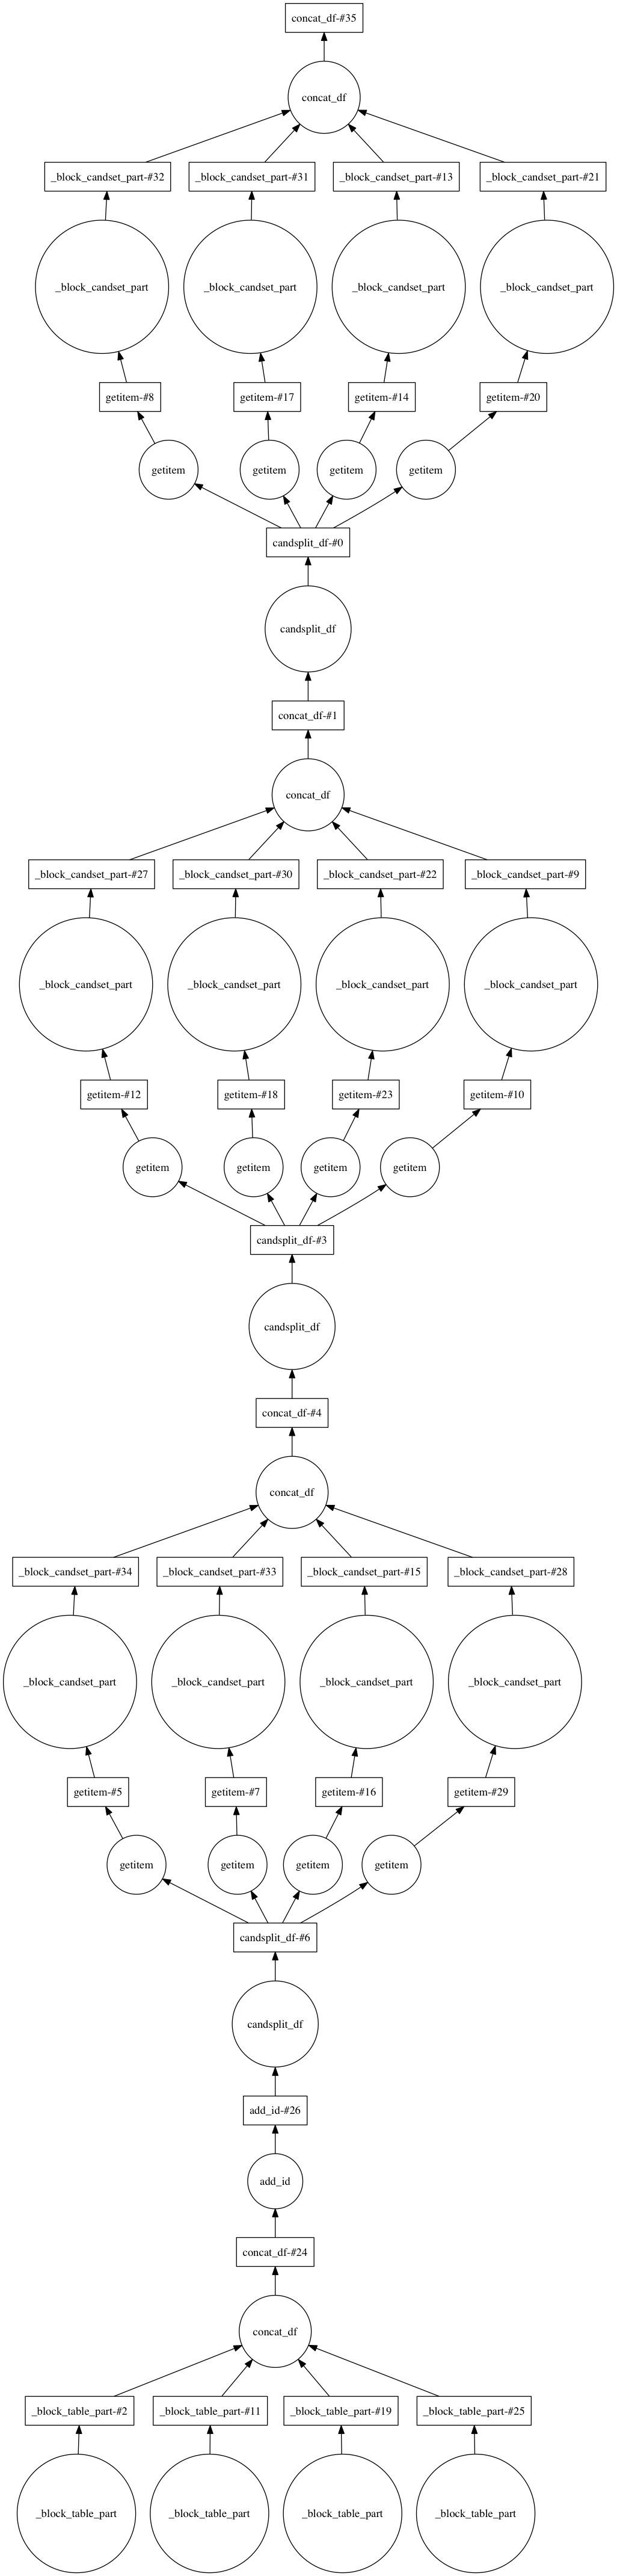

In [3]:
F.visualize()

In [4]:
import py_entitymatching as em

In [5]:
em.save_object(F, './dag-1.pkl')

No handlers could be found for logger "py_entitymatching.io.pickles"


True

In [5]:
datapath = "../../datasets/"
A = pd.read_csv(os.path.join(datapath, 'person_table_A.csv'), low_memory=False)
B = pd.read_csv(os.path.join(datapath, 'person_table_B.csv'), low_memory=False)

# A = pd.read_csv(os.path.join(datapath, 'tracks.csv'), low_memory=False)
# B = pd.read_csv(os.path.join(datapath, 'songs.csv'), low_memory=False)

print('Reading the files done')
ab = AttrEquivalenceBlocker()
C = ab.block_tables(A, B, 'ID', 'ID', 'birth_year', 'birth_year', ['name', 'address',
                                                                   'zipcode'],
                    ['name', 'address', 'zipcode'], nltable_chunks=2, nrtable_chunks=2,
                    compute=False, scheduler=dask.get
                    )
bb = BlackBoxBlocker()
bb.set_black_box_function(last_name_match)
bb.set_ltable_attrs(['name'])
bb.set_rtable_attrs(['name'])
D = bb.block_candset(C, A, B, 'l_ID', 'r_ID', "ID", "ID", nchunks=4,
                    compute=False, scheduler=dask.get)
ob = OverlapBlocker()
E = ob.block_candset(D, A, B, "l_ID", "r_ID", "ID", "ID", 'name', 'name',
                     nchunks=4, overlap_size=1, compute=False, scheduler=dask.get)


Reading the files done


In [6]:
E.compute()

                     x                 y
0  [franklin, michael]  [franklin, mike]
 1
                   x               y
1  [bridge, william]  [bill, bridge]                    x                 y
2  [alphonse, kemper]  [alfons, kemper]

11



,_id,l_ID,r_ID,l_name,l_address,l_zipcode,r_name,r_address,r_zipcode
0,0,1,2,Michael Franklin,"1652 Stockton St, San Francisco",94122,Mike Franklin,"1652 Stockton St, San Francisco",94122
1,1,2,1,William Bridge,"3131 Webster St, San Francisco",94107,Bill Bridge,"3131 Webster St, San Francisco",94107
2,4,4,4,Alphonse Kemper,"1702 Post Street, San Francisco",94122,Alfons Kemper,"170 Post St, Apt 4, San Francisco",94122
